In [14]:
import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gym
from gym import wrappers, logger
import pandas as pd
import numpy as np
import random
import copy
import torch
from torch import nn
from torch import *
import torch.optim as optim
from torch.distributions import Categorical
from tqdm import tqdm_notebook as tqdm
import os,sys,inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from modules.utils import ReplayMemory, NeuralNet
from modules.A2C import A2CAgent

In [21]:
if __name__ == '__main__':

    ### hyper-parameters ###
    gamma = 0.99

    ### Environment setting ###
    #env_name = 'CartPole-v1'
    env_name = 'LunarLander-v2'
    env = gym.make(env_name)
    outdir = env_name + '/A2C-results'
    
    
    
    envm = wrappers.Monitor(env, directory=outdir, force=True, video_callable=False)
    env.seed(0)
    env.reset()
    done = False
    verbose = False
    
    batch_size = 10
    replay_mem = ReplayMemory(batch_size=batch_size) 
    
    action_size = env.action_space.n 
    state_size = env.observation_space.shape[0]
    layers_actor = [10, 10, 10]
    layers_critic = [10, 10, 10]

    
    rollout = True
    
    ### Initialization ### Actor + Critic
    a2c = A2CAgent(actor = NeuralNet(state_size, action_size, layers_actor).double(),
                   critic = NeuralNet(state_size, 1, layers_critic, soft=False).double())


    ### Training Settings ###
    episode_count = 1500
    optimizerActor = optim.Adam(a2c.actor.parameters())
    optimizerCritic = optim.Adam(a2c.critic.parameters())
    huberLoss = nn.SmoothL1Loss()

    rsum_hist = []

    ### Training loop ###
    t = tqdm(range(episode_count), desc="Episod : rsum : iter :")

    for episode in t:

        it = 0
        obs = envm.reset()
        rsum = 0.0
        done = False

        while(True):

            if verbose == True:
                env.render()
            
            state = obs
            action = a2c.act(state)
            obs, reward, done, _ = envm.step(action.item())
            rsum += reward
            it += 1
            
            if rollout:
                replay_mem.store(state, action, reward, obs, done)
                
            else:
                critic_loss, actor_loss = a2c.compute_loss(state, action, reward, obs, done, gamma)
                
                ## critic loss ##
                optimizerCritic.zero_grad()
                critic_loss.backward()
                optimizerCritic.step()

                ## actor loss ##
                optimizerActor.zero_grad()
                actor_loss.backward()
                optimizerActor.step()
            
            if done == True:
                t.set_description(desc="Episode :%d, rsum=%.2f, iter = %d"%(episode, rsum, it), refresh=True)
                t.refresh()
                rsum_hist.append(rsum)
                break
                
        if rollout :
            states, actions, rewards, obss, dones = replay_mem.pop(batch_size=len(replay_mem))    
            critic_loss, actor_loss = a2c.compute_loss(states, actions, rewards, obss, dones, gamma)

            ## critic loss ##
            optimizerCritic.zero_grad()
            critic_loss.backward()
            optimizerCritic.step()

            ## actor loss ##
            optimizerActor.zero_grad()
            actor_loss.backward()
            optimizerActor.step()
            

env.close()

/home/oussama/Desktop/M2A/RLDL/modules/utils.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.stack([torch.tensor(exp.action) for exp in batch])
/home/oussama/Desktop/M2A/RLDL/modules/A2C.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = rewards + gamma * next_values * (1.0 - torch.tensor(dones).double())


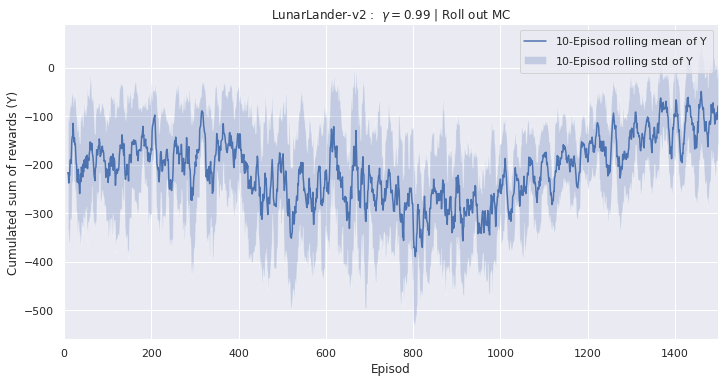

In [22]:
window = 10
data = pd.concat([pd.Series(rsum_hist, name='mean').rolling(window).mean(),
          pd.Series(rsum_hist, name='std').rolling(window).std()],
          axis=1)

sns.set()
plt.figure(figsize=(10,5))
ax = data['mean'].plot()

ax.fill_between(data.index, data['mean'] - data['std'], data['mean'] + data['std'],
                alpha=.25)
plt.tight_layout()
plt.ylabel("Cumulated sum of rewards (Y)")

if rollout:
    title = '%s :  $\gamma = %.2f$ | Roll out MC'%(env_name, gamma)
else:
    title = '%s :  $\gamma = %.2f$ | online'%(env_name, gamma)
    
plt.title(title)

plt.legend(['$%d$-Episod rolling mean of Y'%window, '$%d$-Episod rolling std of Y'%window])
plt.xlabel('Episod')
sns.despine()
